# Evaluation of CNN for Hierarchical Parameters

Author: Patricia Fuchs

### Imports

In [1]:
# Imports 
from tensorflow.keras.layers import Input, Dense, Dropout, Normalization, Activation, Conv2D, MaxPooling2D, Flatten
import argparse
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json
from nn.util_paras import load_preprocess_paras, write_configs, reload_aorta_segs_from_piginfo,check_resampled_paras
from tensorflow import distribute as dist
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from src.reconstruction import split_y, append_y
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from nn.evaluation_fcts import *
import numpy as np
from nn.eva_metrics import EvaMetrics
import os
from os.path import join
from glob import glob
from nn.help_function_training import *
import warnings
warnings.filterwarnings('ignore')
from nn.aorta import AortaNormalizer

2025-02-05 13:39:24.695658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 13:39:28.019337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Initialization

In [2]:
data_path = "/home/pfuchs/Data/"
mprefix = '/home/pfuchs/nn/models/'
training_examples = ["P01_PulHyp","P02_PulHyp","P03_PulHyp","P04_PulHyp","P05_PulHyp","P06_PulHyp","P07_PulHyp", "P08_PulHyp", "P09_PulHyp","P10_PulHyp"]
data_prefix = "/home/pfuchs/Data/Data_npz/PulHyp_k18_18HierRescaled/Data_PolyHierarchical/"
# modelpath = "20250130-020810/"
modelpath = "model_hier/"

path = mprefix + modelpath
venttype = "start"
sNormAorta = "fixed"
iParaLen = 43

### Loading Model

In [3]:
bResampleParas = False
sParaType = "PolyHierarchicalLin"

# Test pig
iTestpig= 8
iNpigs = len(training_examples)
test_pig = training_examples[iTestpig]

model = tf.keras.models.load_model(mprefix+modelpath+"model.keras")
model.summary()

2025-02-05 13:39:35.200933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 1024,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 256,   │        164 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 256,   │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 256,   │          0 │ batch_normalizat… │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 256,   │          0 │ activation[0][0]  │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 128,   │         65 │ dropout[0][0]     │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │         20 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 128,   │          0 │ activation_1[0][… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 64, 7) │        707 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 64, 7) │         28 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 11, 64, 7) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 11, 64, 7) │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 32, 9)  │      1,899 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 32, 9)  │         36 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 32, 9)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 32, 9)  │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 488,281 (1.86 MB)

 Trainable params: 162,743 (635.71 KB)

 Non-trainable params: 50 (200.00 B)

 Optimizer params: 325,488 (1.24 MB)

### Loading Test Data

In [4]:
print("Test pig: " +str(test_pig))
X_test, y_test, vsig_test, p_test = load_preprocess_paras(
    data_prefix,
    [test_pig],
    zero_padding=False,
    shuffle=False,
    eit_length=64,
    aorta_length=1400,
    para_len=iParaLen,
    norm_eit="block",
    norm_aorta=sNormAorta,
    loadVent= venttype,
    resample_paras=bResampleParas,
)
if sNormAorta == "fixed":
    AortaNorm = AortaNormalizer(paratype=sParaType, mode=sNormAorta)
    y_test = AortaNorm.normalize_forward(y_test)
print("Loading test data finished.")

Test pig: P09_PulHyp
Loading data from /home/pfuchs/Data/Data_npz/PulHyp_k18_18HierRescaled/Data_PolyHierarchical/P09_PulHyp
Start normalizing EIT.
Finished normalizing EIT.
Finished resampling aortic parameters.
Init Aorta normalizer with
 Paratype=PolyHierarchicalLin and Mode=fixed.
Loading test data finished.


### Evaluate Model

In [5]:
(y_test_preds1, y_test_preds2) = model([X_test, vsig_test])
y_test_preds = append_y(y_test_preds1, y_test_preds2, iLen=1)
del X_test, y_test_preds1, y_test_preds2


# Visualization ----------------------------------------------------------------------------- #
bPlotGraphics = False
bShowGraphics= True

y_test_recon = recon_paras_block(y_test, sParaType, bScale=False, Denorm=sNormAorta)
y_test_preds_recon = recon_paras_block(y_test_preds, sParaType, bScale=False, Denorm=sNormAorta)
y_test_recon_a, y_test_preds_recon_a = set_array_len(y_test_recon, y_test_preds_recon, 1024)
print("Reconstruction complete.")
#y_test_real = np.array(reload_aorta_segs_from_piginfo(data_path, p_test, bRemovedMin,bResampled=TP.bResampleParas, iResampleLen=1024, sNormAorta=TP.sNormAorta))
y_test_real = y_test_recon_a
del y_test_recon, y_test_preds_recon


Init Aorta normalizer with
 Paratype=PolyHierarchicalLin and Mode=fixed.
Init Aorta normalizer with
 Paratype=PolyHierarchicalLin and Mode=fixed.
Reconstruction complete.


### Visualization

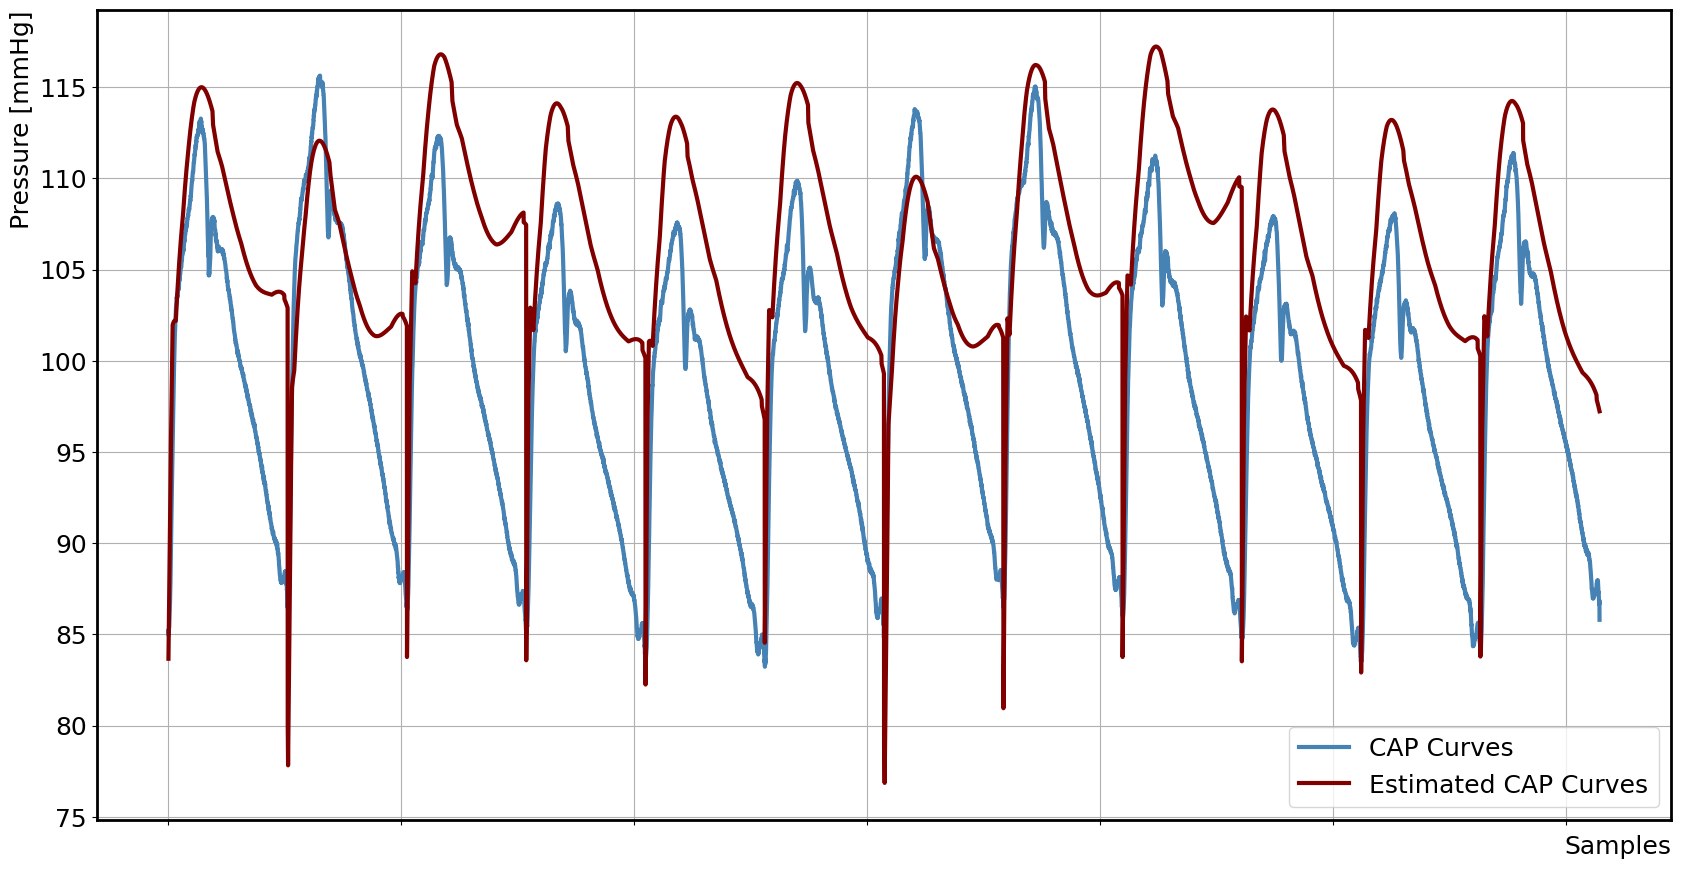

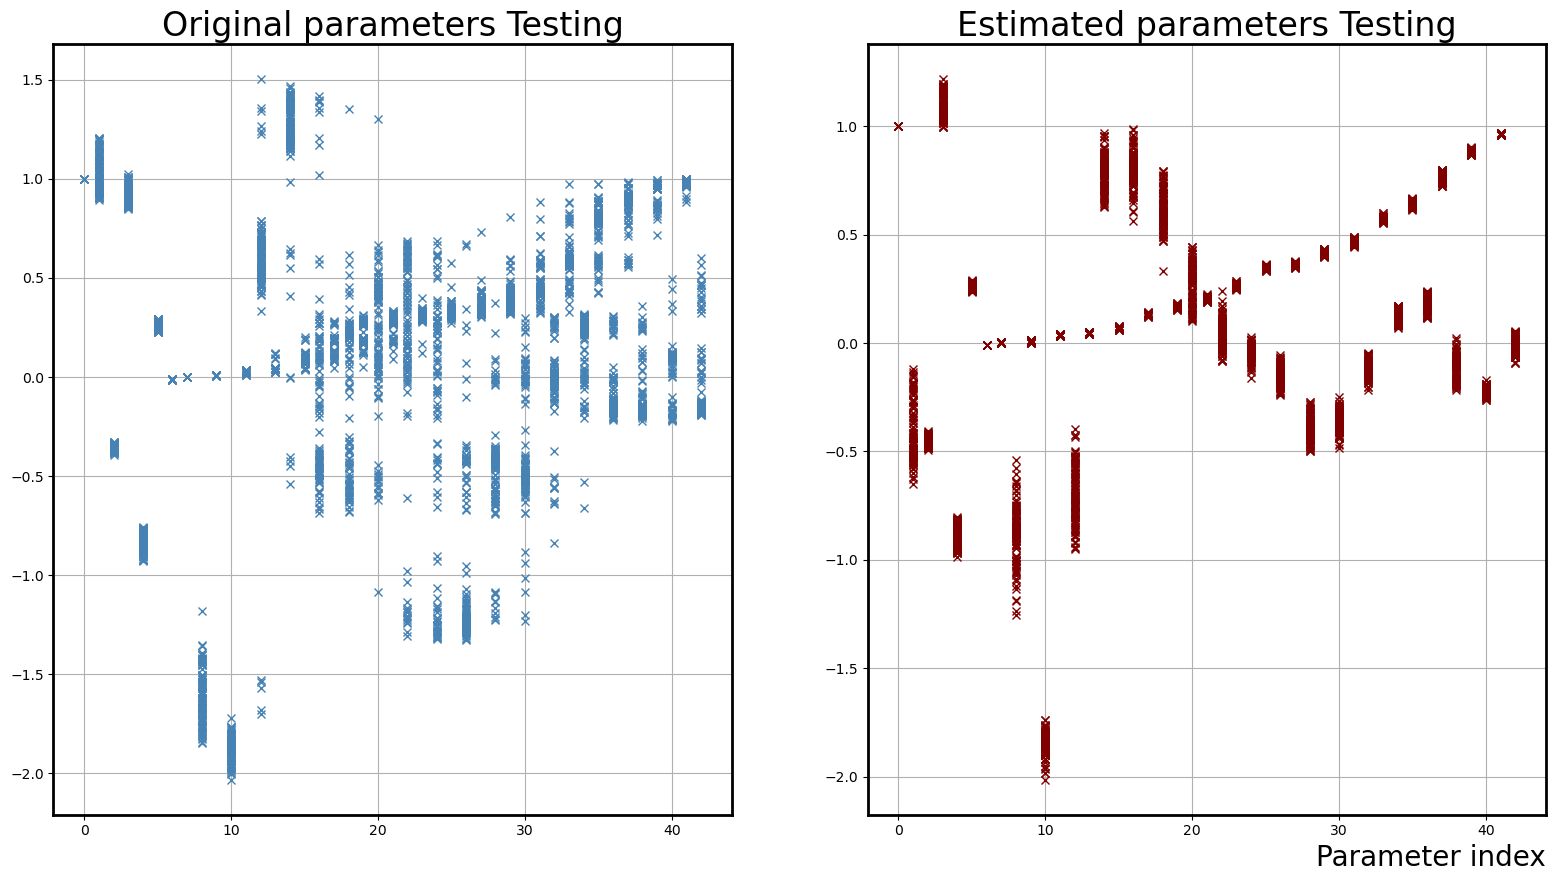

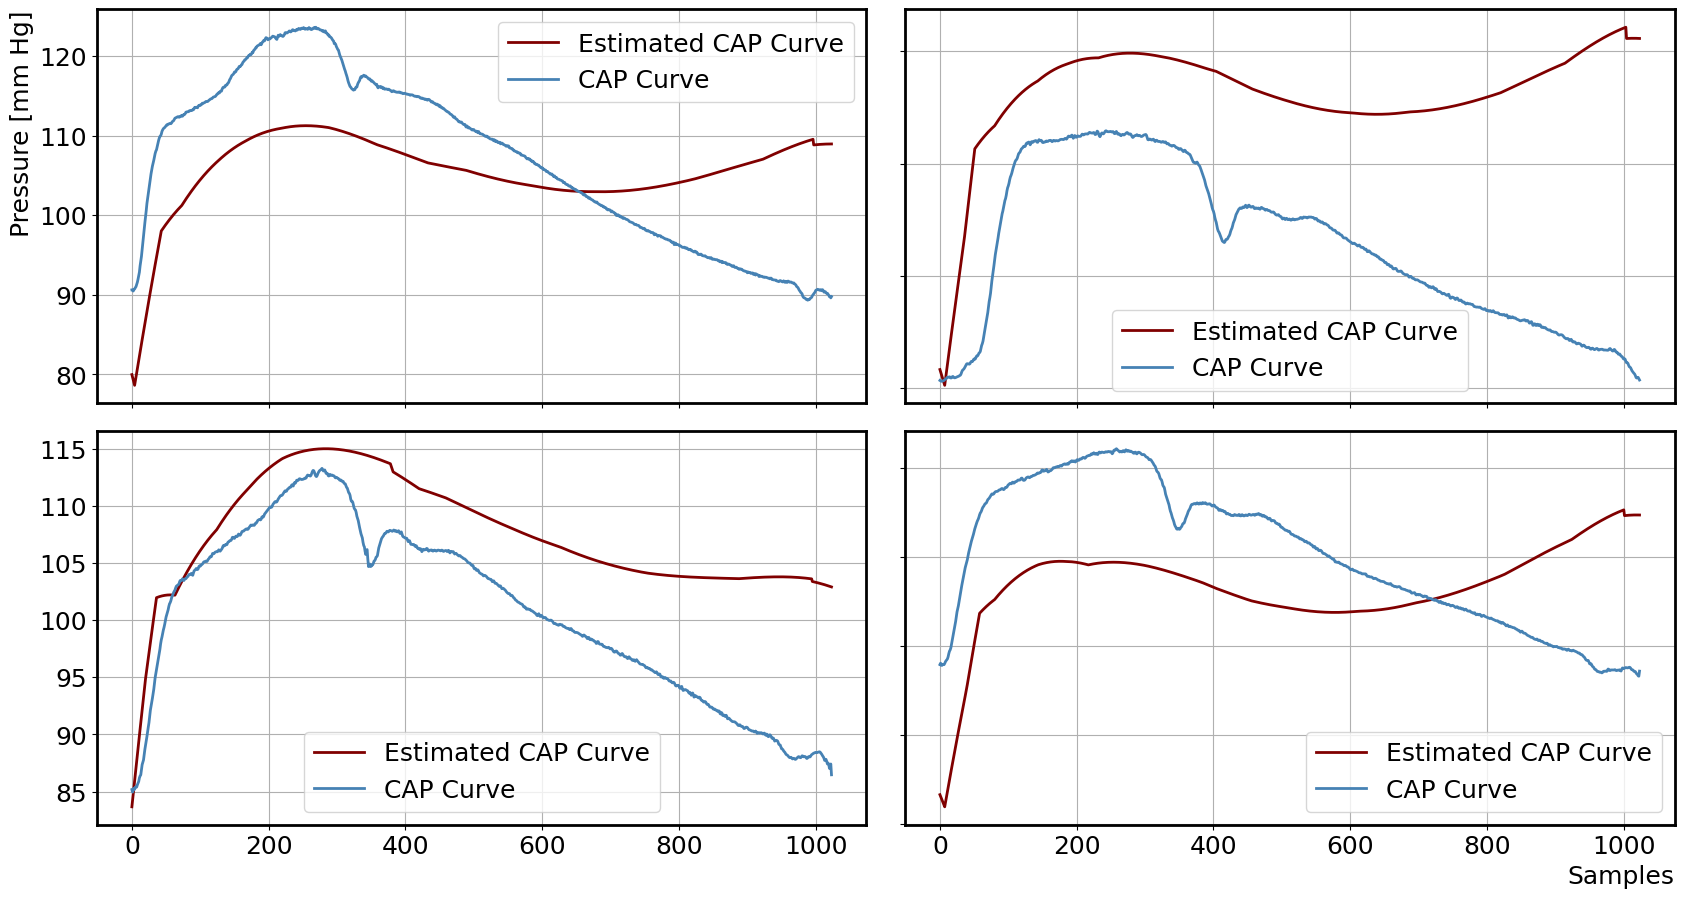

{'Testing': {'Curve': {'MAE': 11.930690861115819, 'MSE': 229.7680904937834, 'PearsonR': 0.24790103912673295, 'PearsonP': 0.0, 'SpearmanRs': 0.22710121561093424, 'R2': -1.3361442218542727, 'MeanError': 0.6215890602043458, 'VarError': 229.38171753401767, 'MAEmean': 10.538799489707745, 'Rmean': 0.13551071967339512, 'MAEform': -1.5822, 'Rform': 0.5279129243524925}, 'Paras': {'MAE': 0.25235887253280676, 'MSE': 0.1916617065874293, 'PearsonR': 0.7247339759204173, 'PearsonP': 0.0}}, 'Validation': {}}
MAE:  11.930690861115819
MSE:  229.7680904937834
Pearson:  0.24790103912673295
MSE of blockwise mean-compensated Results 222.79960324750093
MAE of blockwise mean-compensated Results 12.377254980684226
Testing finished.


In [6]:
y_test_real = np.array(reload_aorta_segs_from_piginfo(data_path, p_test[5000:5012], False,bResampled=True, iResampleLen=1024, sNormAorta=sNormAorta))
plot_appended_recon_curves(y_test_preds_recon_a[5000:5012], y_test_real, "Testing Reconstructed Signals", sParaType, recon_given=True, bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)

plot_parameters(y_test_preds, y_test,"Testing", bSave=bPlotGraphics,fSavePath=path, bShow=bShowGraphics)

ind = [800,7100,5000,7000]
pig_plot = []
for k in ind:
    pig_plot.append(p_test[k])
aorta_seg_test = reload_aorta_segs_from_piginfo(data_path, pig_plot, False, sNormAorta=sNormAorta, bResampled=True, iResampleLen=1024, )
plot_4_recon_curves_paper(y_test_preds_recon_a, aorta_seg_test, "Testing Reconstructed Signal", sParaType, recon_given=True,ind=ind, bSave=bPlotGraphics,fSavePath=path, bShow=True)

# Or load real segments
#y_test_real = np.array(reload_aorta_segs_from_piginfo(data_path, p_test, False,bResampled=True, iResampleLen=1024, sNormAorta=sNormAorta))
M = EvaMetrics(path)
M.bByParatype = False
M.bVisualMetrics = False
M.calc_metrics(y_test_recon_a, y_test_preds_recon_a, sParaType, "TestCurve", bSave=bPlotGraphics)
M.calc_metrics(y_test, y_test_preds, sParaType, "TestParas", bParas=True, bSave=bPlotGraphics)


M.gather_info()
print(M.metrics["Compact"])
print("MAE: ", M.metrics["Compact"]["Testing"]["Curve"]["MAE"])
print("MSE: ", M.metrics["Compact"]["Testing"]["Curve"]["MSE"])
print("Pearson: ", M.metrics["Compact"]["Testing"]["Curve"]["PearsonR"])

consecutive_error_blockwise(y_test_recon_a, y_test_preds_recon_a, p_test)
print("Testing finished.")